In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [2]:

# Read the pickle object
with open("/home/anirudha/COL707/doh_traffic_analysis/dataset/pickles/LOC3.pickle", "rb") as f:
    data = pickle.load(f)

# Convert the data to a pandas dataframe
df = pd.DataFrame(data)

# Encode the class labels
label_encoder = LabelEncoder()
df['class_label'] = label_encoder.fit_transform(df['class_label'])

# Define the maximum sequence length
max_len = 0
for i in df['lengths']:
    max_len=max(max_len,len(i))

# Pad the sequences to the maximum length
sequences = np.array(df['lengths'])
padded_sequences = np.zeros((len(sequences), max_len))
for i, sequence in enumerate(sequences):
    padded_sequences[i, :len(sequence)] = sequence

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, df['class_label'], test_size=0.2)

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).to(torch.float32)
y_train = torch.from_numpy(y_train.values).long()
X_val = torch.from_numpy(X_val).to(torch.float32)
y_val = torch.from_numpy(y_val.values).long()
# check if split is stratified
# print("Training set class distribution:")
# print(y_train.unique(return_counts=True)) 
# print("Validation set class distribution:")
# print(y_val.unique(return_counts=True))
print(y_train.unique().shape)
print(y_val.unique().shape)
print(X_train.shape)
print(X_val.shape)

torch.Size([1500])
torch.Size([1500])
torch.Size([123946, 1213])
torch.Size([30987, 1213])


In [3]:
# Define a custom dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        sequence = self.sequences[index]
        label = self.labels[index]
        return sequence, label


In [4]:

# Initialize the model
input_dim=0
for i in X_train:
    input_dim = max(input_dim,len(i))
# input_dim = len(X_train[0])
hidden_dim = 128
output_dim = 1500
learning_rate = 1e-3
print(input_dim)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Define the dataloaders
train_dataset = SequenceDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SequenceDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


1213


In [5]:
# Define the model architecture
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size):
        super(RNN, self).__init__()
        self.batch_size=batch_size
        # simple 1d conv 
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu = nn.ReLU()        
        
        # parameters for the RNN
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        # define the RNN
        # self.rnn = nn.LSTM(8*input_dim, hidden_dim, batch_first=True)
        self.rnn = nn.RNN(8*input_dim, hidden_dim, batch_first=True)
        # define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)    
        self.h = self.init_hidden(self.batch_size)    
        self.flatten = nn.Flatten()
        # self.fc = nn.Linear(8*input_dim, output_dim)
        
    def init_hidden(self, bsz):
        # initialize the hidden state
        self.h=torch.zeros(1, bsz, self.hidden_dim).to(device)
    
    def forward(self, x):
        # reshape the input
        # x = x.view(self.batch_size, self.input_dim, -1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.flatten(x)
        # initialize the hidden state
        self.init_hidden(x.shape[0])
        # get RNN unit outputs
        out, h = self.rnn(x.unsqueeze(1), self.h)
        # get the output for the last time step
        out = self.fc(out[:, -1, :])
        return out


In [6]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
rnn = RNN(input_dim, hidden_dim, output_dim, batch_size=64)
rnn = rnn.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


Using device: cuda:6


In [20]:
from sklearn.metrics import precision_recall_fscore_support
def get_precision_recall_f1(y_true, y_pred):
    """Calculate precision, recall, F1 score for each class.
    Args:
        y_true (list): list of true labels
        y_pred (list): list of predicted labels
    Returns:
        dict: dictionary with precision, recall, F1 score for each class
    """
    # Calculate precision, recall, F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

num_epochs = 300
# optimizer = optimizer.to(device)
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    rnn.train()
    for sequences, labels in train_loader:
        optimizer.zero_grad()
        labels = labels.to(device)
        sequences = sequences.to(device)
        sequences = sequences.unsqueeze(1)
        outputs = rnn(sequences)
        
        # print(sequences.shape)
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() /len(train_dataset)
    print('Train Loss: {:.4f} Train Acc: {:.4f} %'.format(epoch_loss, epoch_acc*100))
    
    # test the model
    rnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_preds = []
        total_labels = []
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            sequences = sequences.unsqueeze(1)
            outputs = rnn(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_preds.append(predicted)
            total_labels.append(labels)
        
        print('Epoch: {}, Test Accuracy of the model on the test sequences: {} %'.format(epoch, 100 * correct / total))
        total_preds = torch.cat(total_preds, dim=0)
        total_labels = torch.cat(total_labels, dim=0)
        print(get_precision_recall_f1(total_labels.cpu(), total_preds.cpu()))

Train Loss: 0.3988 Train Acc: 88.2610 %
Epoch: 0, Test Accuracy of the model on the test sequences: 88.47903959725046 %
{'precision': 0.8987437933239669, 'recall': 0.8848424834915621, 'f1': 0.8809900462948047}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3589 Train Acc: 89.0678 %
Epoch: 1, Test Accuracy of the model on the test sequences: 88.4887210765805 %
{'precision': 0.8990339992641869, 'recall': 0.8859817401638318, 'f1': 0.8816113826177152}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3416 Train Acc: 89.3954 %
Epoch: 2, Test Accuracy of the model on the test sequences: 87.7755187659341 %
{'precision': 0.8922362646414499, 'recall': 0.8784863867963034, 'f1': 0.8734407288051779}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3321 Train Acc: 89.5785 %
Epoch: 3, Test Accuracy of the model on the test sequences: 87.51411882402297 %
{'precision': 0.886253160048985, 'recall': 0.8766579143149205, 'f1': 0.870199869637471}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3262 Train Acc: 89.7439 %
Epoch: 4, Test Accuracy of the model on the test sequences: 87.88846935811792 %
{'precision': 0.8885400837002495, 'recall': 0.8801867694336954, 'f1': 0.8747549418524665}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3220 Train Acc: 89.7762 %
Epoch: 5, Test Accuracy of the model on the test sequences: 87.43021266982929 %
{'precision': 0.8868619735432995, 'recall': 0.8764302657522682, 'f1': 0.8716119745772133}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3154 Train Acc: 89.9416 %
Epoch: 6, Test Accuracy of the model on the test sequences: 87.42375835027592 %
{'precision': 0.8867758262924765, 'recall': 0.8751451981003369, 'f1': 0.8700407441138434}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3107 Train Acc: 90.0384 %
Epoch: 7, Test Accuracy of the model on the test sequences: 87.42375835027592 %
{'precision': 0.8843219046315876, 'recall': 0.8752941266416546, 'f1': 0.870212032996793}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3079 Train Acc: 90.1191 %
Epoch: 8, Test Accuracy of the model on the test sequences: 86.94936586310388 %
{'precision': 0.8813206574230277, 'recall': 0.8712820953514244, 'f1': 0.8643675948824536}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3049 Train Acc: 90.2062 %
Epoch: 9, Test Accuracy of the model on the test sequences: 87.16881272791817 %
{'precision': 0.880880359806476, 'recall': 0.8724444669668954, 'f1': 0.8674695623707115}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.3021 Train Acc: 90.2950 %
Epoch: 10, Test Accuracy of the model on the test sequences: 86.8783683480169 %
{'precision': 0.8796212647864263, 'recall': 0.8707653063873828, 'f1': 0.8654154415070193}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2995 Train Acc: 90.3563 %
Epoch: 11, Test Accuracy of the model on the test sequences: 87.11395101171459 %
{'precision': 0.881247424670956, 'recall': 0.8730987760785165, 'f1': 0.8674018822801594}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2974 Train Acc: 90.3272 %
Epoch: 12, Test Accuracy of the model on the test sequences: 86.85900538935682 %
{'precision': 0.876149608501185, 'recall': 0.8699742790275947, 'f1': 0.8642055094776182}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2923 Train Acc: 90.5338 %
Epoch: 13, Test Accuracy of the model on the test sequences: 86.70087456029948 %
{'precision': 0.8748386616447011, 'recall': 0.8675635313215241, 'f1': 0.8619303648367799}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2923 Train Acc: 90.4999 %
Epoch: 14, Test Accuracy of the model on the test sequences: 86.70732887985284 %
{'precision': 0.8775417043861231, 'recall': 0.867708688142947, 'f1': 0.8621789230855684}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2876 Train Acc: 90.6935 %
Epoch: 15, Test Accuracy of the model on the test sequences: 86.70087456029948 %
{'precision': 0.878264588301754, 'recall': 0.869500848121332, 'f1': 0.8635111189863164}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2863 Train Acc: 90.6314 %
Epoch: 16, Test Accuracy of the model on the test sequences: 87.06877077484106 %
{'precision': 0.8800106157167245, 'recall': 0.8714590062509954, 'f1': 0.865823720795815}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2859 Train Acc: 90.5951 %
Epoch: 17, Test Accuracy of the model on the test sequences: 86.48465485526188 %
{'precision': 0.8721505127444897, 'recall': 0.8654873505755701, 'f1': 0.8606660781451346}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2833 Train Acc: 90.6976 %
Epoch: 18, Test Accuracy of the model on the test sequences: 86.27166231000096 %
{'precision': 0.8720748874959217, 'recall': 0.8636729017212178, 'f1': 0.8578677444048869}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2811 Train Acc: 90.7645 %
Epoch: 19, Test Accuracy of the model on the test sequences: 86.49110917481525 %
{'precision': 0.8732497559324525, 'recall': 0.865894520328396, 'f1': 0.8604549890587088}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2774 Train Acc: 90.8404 %
Epoch: 20, Test Accuracy of the model on the test sequences: 86.5653338496789 %
{'precision': 0.8717437868801856, 'recall': 0.8672848467728478, 'f1': 0.8610495999444516}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2768 Train Acc: 90.9065 %
Epoch: 21, Test Accuracy of the model on the test sequences: 86.32975118598122 %
{'precision': 0.8716166571747948, 'recall': 0.8648741843777585, 'f1': 0.859449508147868}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2763 Train Acc: 90.8670 %
Epoch: 22, Test Accuracy of the model on the test sequences: 86.32329686642785 %
{'precision': 0.870459665036108, 'recall': 0.8656710882946811, 'f1': 0.8593940764600184}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2737 Train Acc: 90.9670 %
Epoch: 23, Test Accuracy of the model on the test sequences: 86.27166231000096 %
{'precision': 0.8703586984778315, 'recall': 0.8640389472346564, 'f1': 0.8585573241177864}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2710 Train Acc: 91.0340 %
Epoch: 24, Test Accuracy of the model on the test sequences: 86.19098331558395 %
{'precision': 0.8699396850718947, 'recall': 0.8642005293659221, 'f1': 0.8587156125444629}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2670 Train Acc: 91.1655 %
Epoch: 25, Test Accuracy of the model on the test sequences: 86.13612159938039 %
{'precision': 0.8719916161756297, 'recall': 0.8633932293786417, 'f1': 0.8587827944049697}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2673 Train Acc: 91.0840 %
Epoch: 26, Test Accuracy of the model on the test sequences: 86.3652499435247 %
{'precision': 0.8703551964346734, 'recall': 0.8647953384878659, 'f1': 0.8598059223618342}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2656 Train Acc: 91.2244 %
Epoch: 27, Test Accuracy of the model on the test sequences: 85.66495627198502 %
{'precision': 0.8671005623743077, 'recall': 0.8594796496082824, 'f1': 0.8531058101544949}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2661 Train Acc: 91.1106 %
Epoch: 28, Test Accuracy of the model on the test sequences: 85.9844450898764 %
{'precision': 0.8679987327530768, 'recall': 0.8618631443080566, 'f1': 0.8560608211621362}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2644 Train Acc: 91.1994 %
Epoch: 29, Test Accuracy of the model on the test sequences: 86.18775615580728 %
{'precision': 0.8691968953581706, 'recall': 0.8636354498260389, 'f1': 0.8580870118866722}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2631 Train Acc: 91.2123 %
Epoch: 30, Test Accuracy of the model on the test sequences: 85.86181301836254 %
{'precision': 0.8668429298068753, 'recall': 0.8611832439964701, 'f1': 0.855779671799926}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2595 Train Acc: 91.3349 %
Epoch: 31, Test Accuracy of the model on the test sequences: 86.12321296027366 %
{'precision': 0.8689830323569906, 'recall': 0.8637827745201936, 'f1': 0.8570307278905772}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2593 Train Acc: 91.3196 %
Epoch: 32, Test Accuracy of the model on the test sequences: 85.81017846193565 %
{'precision': 0.8649913061504115, 'recall': 0.8598161056603363, 'f1': 0.8539171220855601}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2586 Train Acc: 91.2865 %
Epoch: 33, Test Accuracy of the model on the test sequences: 86.22970923290413 %
{'precision': 0.8676404529263319, 'recall': 0.8632743077053534, 'f1': 0.8571485418795699}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2585 Train Acc: 91.3293 %
Epoch: 34, Test Accuracy of the model on the test sequences: 86.34588698486462 %
{'precision': 0.8733163836347594, 'recall': 0.8651538928813292, 'f1': 0.8599765460270246}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2549 Train Acc: 91.4285 %
Epoch: 35, Test Accuracy of the model on the test sequences: 85.584277277568 %
{'precision': 0.8625114271983915, 'recall': 0.8570797353783998, 'f1': 0.8514239281986357}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2550 Train Acc: 91.3769 %
Epoch: 36, Test Accuracy of the model on the test sequences: 85.9360376932262 %
{'precision': 0.8682904221181116, 'recall': 0.861078711292664, 'f1': 0.8555517058072422}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2518 Train Acc: 91.5697 %
Epoch: 37, Test Accuracy of the model on the test sequences: 86.10707716139027 %
{'precision': 0.8700216210375544, 'recall': 0.862465836255213, 'f1': 0.8575490365588545}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2523 Train Acc: 91.5052 %
Epoch: 38, Test Accuracy of the model on the test sequences: 85.81985994126569 %
{'precision': 0.8652208653483829, 'recall': 0.859566732349547, 'f1': 0.8542647526834479}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2512 Train Acc: 91.5495 %
Epoch: 39, Test Accuracy of the model on the test sequences: 85.6359118339949 %
{'precision': 0.8613658179137695, 'recall': 0.8580839821319047, 'f1': 0.8512322456760921}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2493 Train Acc: 91.5431 %
Epoch: 40, Test Accuracy of the model on the test sequences: 85.97476361054636 %
{'precision': 0.8637918196178951, 'recall': 0.8605701828753575, 'f1': 0.8543213821649298}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2473 Train Acc: 91.6536 %
Epoch: 41, Test Accuracy of the model on the test sequences: 85.89408461612935 %
{'precision': 0.8663125090048264, 'recall': 0.860949207007467, 'f1': 0.8556708454065042}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2467 Train Acc: 91.6528 %
Epoch: 42, Test Accuracy of the model on the test sequences: 85.6036402362281 %
{'precision': 0.8619521145113869, 'recall': 0.8573014451909394, 'f1': 0.8516192167012826}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2450 Train Acc: 91.6706 %
Epoch: 43, Test Accuracy of the model on the test sequences: 85.79081550327557 %
{'precision': 0.8625372171388705, 'recall': 0.8593205105663827, 'f1': 0.8534509691826723}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2443 Train Acc: 91.7012 %
Epoch: 44, Test Accuracy of the model on the test sequences: 85.6359118339949 %
{'precision': 0.8626765291922173, 'recall': 0.8588199873121269, 'f1': 0.8522010064462843}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2445 Train Acc: 91.6899 %
Epoch: 45, Test Accuracy of the model on the test sequences: 85.89731177590602 %
{'precision': 0.8641112338112197, 'recall': 0.8602794096707658, 'f1': 0.8555600470464675}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2432 Train Acc: 91.7133 %
Epoch: 46, Test Accuracy of the model on the test sequences: 85.30674153677349 %
{'precision': 0.8614271465849194, 'recall': 0.8553567229844355, 'f1': 0.8498866963596047}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2430 Train Acc: 91.7303 %
Epoch: 47, Test Accuracy of the model on the test sequences: 85.4358279278407 %
{'precision': 0.8627583305887406, 'recall': 0.8561061309855382, 'f1': 0.8499293042386359}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2414 Train Acc: 91.7867 %
Epoch: 48, Test Accuracy of the model on the test sequences: 85.40032917029723 %
{'precision': 0.8609117179514612, 'recall': 0.8548344856705308, 'f1': 0.8491902586721655}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2413 Train Acc: 91.7295 %
Epoch: 49, Test Accuracy of the model on the test sequences: 85.7682253848388 %
{'precision': 0.8621860573079657, 'recall': 0.8588692382549473, 'f1': 0.8524613314896884}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2396 Train Acc: 91.7464 %
Epoch: 50, Test Accuracy of the model on the test sequences: 85.58750443734469 %
{'precision': 0.8618874521896538, 'recall': 0.8571075260811422, 'f1': 0.852101902422631}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2372 Train Acc: 91.8561 %
Epoch: 51, Test Accuracy of the model on the test sequences: 85.44228224739408 %
{'precision': 0.8605066301541607, 'recall': 0.8554883541867023, 'f1': 0.849792484125127}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2390 Train Acc: 91.8545 %
Epoch: 52, Test Accuracy of the model on the test sequences: 85.22928970213316 %
{'precision': 0.8581306787025141, 'recall': 0.8543033572145619, 'f1': 0.8486880670191345}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2365 Train Acc: 91.9021 %
Epoch: 53, Test Accuracy of the model on the test sequences: 85.25833414012328 %
{'precision': 0.8603732807235444, 'recall': 0.8539320660136315, 'f1': 0.8482134568944503}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2358 Train Acc: 91.9505 %
Epoch: 54, Test Accuracy of the model on the test sequences: 85.05179591441572 %
{'precision': 0.8571228493088763, 'recall': 0.8521911607999864, 'f1': 0.8455193424196695}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2327 Train Acc: 92.0118 %
Epoch: 55, Test Accuracy of the model on the test sequences: 85.24542550101656 %
{'precision': 0.8588604233564141, 'recall': 0.8553188914733036, 'f1': 0.8486188636397425}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2350 Train Acc: 91.9489 %
Epoch: 56, Test Accuracy of the model on the test sequences: 85.26156129989995 %
{'precision': 0.8588167493457167, 'recall': 0.8546307168455434, 'f1': 0.8486551684824429}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2341 Train Acc: 91.9812 %
Epoch: 57, Test Accuracy of the model on the test sequences: 85.16474650659954 %
{'precision': 0.857963466300747, 'recall': 0.8533815848782221, 'f1': 0.8471770591115546}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2312 Train Acc: 92.0014 %
Epoch: 58, Test Accuracy of the model on the test sequences: 85.22283538257979 %
{'precision': 0.857689502841871, 'recall': 0.8533812629488534, 'f1': 0.8471064252860127}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2334 Train Acc: 91.9989 %
Epoch: 59, Test Accuracy of the model on the test sequences: 85.13247490883273 %
{'precision': 0.856306903180619, 'recall': 0.8534026855864513, 'f1': 0.8471689675279539}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2313 Train Acc: 92.1135 %
Epoch: 60, Test Accuracy of the model on the test sequences: 85.3712847323071 %
{'precision': 0.8593060168465897, 'recall': 0.8555642972102501, 'f1': 0.8502159318994909}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2301 Train Acc: 92.0546 %
Epoch: 61, Test Accuracy of the model on the test sequences: 85.22606254235647 %
{'precision': 0.8575147999213082, 'recall': 0.8535393027206665, 'f1': 0.8481245613200306}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2300 Train Acc: 92.0917 %
Epoch: 62, Test Accuracy of the model on the test sequences: 85.24865266079324 %
{'precision': 0.8580263901451305, 'recall': 0.8533421968121917, 'f1': 0.8482388526524843}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2278 Train Acc: 92.1175 %
Epoch: 63, Test Accuracy of the model on the test sequences: 85.1712008261529 %
{'precision': 0.8564613564034156, 'recall': 0.8532490808333044, 'f1': 0.8473214557971099}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2273 Train Acc: 92.1288 %
Epoch: 64, Test Accuracy of the model on the test sequences: 85.08406751218253 %
{'precision': 0.8557044031381611, 'recall': 0.8532402170050409, 'f1': 0.8462180402804079}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2278 Train Acc: 92.0699 %
Epoch: 65, Test Accuracy of the model on the test sequences: 84.98725271888212 %
{'precision': 0.8561265471964612, 'recall': 0.8516156179117391, 'f1': 0.8455894653135999}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2273 Train Acc: 92.1038 %
Epoch: 66, Test Accuracy of the model on the test sequences: 84.91948236357182 %
{'precision': 0.8548071048398356, 'recall': 0.8510573622059889, 'f1': 0.8450771837415864}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2259 Train Acc: 92.1143 %
Epoch: 67, Test Accuracy of the model on the test sequences: 85.35837609320038 %
{'precision': 0.8594249925829917, 'recall': 0.8542709447564394, 'f1': 0.8493497289076222}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2251 Train Acc: 92.1748 %
Epoch: 68, Test Accuracy of the model on the test sequences: 85.01952431664891 %
{'precision': 0.8586123191930553, 'recall': 0.8514440399359293, 'f1': 0.8466548780897094}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2236 Train Acc: 92.2434 %
Epoch: 69, Test Accuracy of the model on the test sequences: 85.21315390324975 %
{'precision': 0.8579890007946038, 'recall': 0.8540545844788201, 'f1': 0.8479171484214523}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2224 Train Acc: 92.2837 %
Epoch: 70, Test Accuracy of the model on the test sequences: 85.30028721722013 %
{'precision': 0.8604145790193949, 'recall': 0.8545420986369391, 'f1': 0.8498641654935224}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2243 Train Acc: 92.1611 %
Epoch: 71, Test Accuracy of the model on the test sequences: 85.34546745409365 %
{'precision': 0.8614341244388136, 'recall': 0.855824178342577, 'f1': 0.8507763662603247}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2228 Train Acc: 92.1990 %
Epoch: 72, Test Accuracy of the model on the test sequences: 85.0550230741924 %
{'precision': 0.8562701481825983, 'recall': 0.8524589086466909, 'f1': 0.8461939643547348}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2195 Train Acc: 92.3346 %
Epoch: 73, Test Accuracy of the model on the test sequences: 84.92593668312519 %
{'precision': 0.8555202387601337, 'recall': 0.8509583000138652, 'f1': 0.8458132472502417}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2217 Train Acc: 92.2821 %
Epoch: 74, Test Accuracy of the model on the test sequences: 85.21638106302643 %
{'precision': 0.8564738728251325, 'recall': 0.8534875512165591, 'f1': 0.8485718728646152}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2211 Train Acc: 92.3104 %
Epoch: 75, Test Accuracy of the model on the test sequences: 84.85493916803821 %
{'precision': 0.8539279847710398, 'recall': 0.850373212355899, 'f1': 0.8443051819440964}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2188 Train Acc: 92.4467 %
Epoch: 76, Test Accuracy of the model on the test sequences: 84.96143544066867 %
{'precision': 0.8567420623941052, 'recall': 0.8520634227251791, 'f1': 0.8463585845230139}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2188 Train Acc: 92.3451 %
Epoch: 77, Test Accuracy of the model on the test sequences: 85.24542550101656 %
{'precision': 0.8586637536542782, 'recall': 0.8540317774852955, 'f1': 0.8491107177815799}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2190 Train Acc: 92.3507 %
Epoch: 78, Test Accuracy of the model on the test sequences: 85.04534159486236 %
{'precision': 0.8553951043126966, 'recall': 0.8520589946780941, 'f1': 0.8461459533686237}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2178 Train Acc: 92.3523 %
Epoch: 79, Test Accuracy of the model on the test sequences: 85.01629715687224 %
{'precision': 0.8556673092005685, 'recall': 0.8519515990328164, 'f1': 0.8459517418963648}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2159 Train Acc: 92.5056 %
Epoch: 80, Test Accuracy of the model on the test sequences: 85.12924774905606 %
{'precision': 0.8566538845429392, 'recall': 0.8530902027870272, 'f1': 0.8473679948741019}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2201 Train Acc: 92.3354 %
Epoch: 81, Test Accuracy of the model on the test sequences: 85.12279342950269 %
{'precision': 0.8553022259819864, 'recall': 0.8530748560284966, 'f1': 0.846352989300961}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2171 Train Acc: 92.4330 %
Epoch: 82, Test Accuracy of the model on the test sequences: 85.02920579597895 %
{'precision': 0.8562660535998051, 'recall': 0.8525349962313845, 'f1': 0.8467619969004359}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2182 Train Acc: 92.3031 %
Epoch: 83, Test Accuracy of the model on the test sequences: 84.90980088424178 %
{'precision': 0.8530171335254499, 'recall': 0.8505807360836243, 'f1': 0.844369921910176}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2152 Train Acc: 92.3959 %
Epoch: 84, Test Accuracy of the model on the test sequences: 84.78071449317456 %
{'precision': 0.8552338054941374, 'recall': 0.8505656095318633, 'f1': 0.8445718638457229}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2149 Train Acc: 92.3838 %
Epoch: 85, Test Accuracy of the model on the test sequences: 84.85816632781489 %
{'precision': 0.8546459670907577, 'recall': 0.8499665606223442, 'f1': 0.844012297149262}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2132 Train Acc: 92.5048 %
Epoch: 86, Test Accuracy of the model on the test sequences: 84.97757123955208 %
{'precision': 0.8565893073288695, 'recall': 0.8517340776251594, 'f1': 0.8468183759207589}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2123 Train Acc: 92.5096 %
Epoch: 87, Test Accuracy of the model on the test sequences: 84.42249975796301 %
{'precision': 0.8520183409680376, 'recall': 0.8462833014161996, 'f1': 0.8407270383188806}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2143 Train Acc: 92.4854 %
Epoch: 88, Test Accuracy of the model on the test sequences: 84.92593668312519 %
{'precision': 0.8534684504142767, 'recall': 0.850613132159017, 'f1': 0.8448984237213052}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2130 Train Acc: 92.5209 %
Epoch: 89, Test Accuracy of the model on the test sequences: 84.86462064736826 %
{'precision': 0.8536183531436903, 'recall': 0.8512619621014328, 'f1': 0.8446017885753319}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2119 Train Acc: 92.5096 %
Epoch: 90, Test Accuracy of the model on the test sequences: 84.86784780714493 %
{'precision': 0.8547029860277131, 'recall': 0.8511275588472568, 'f1': 0.8446030770479995}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2123 Train Acc: 92.6032 %
Epoch: 91, Test Accuracy of the model on the test sequences: 84.65485526188401 %
{'precision': 0.8527862630427565, 'recall': 0.848821720015813, 'f1': 0.8432135674578294}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2096 Train Acc: 92.5798 %
Epoch: 92, Test Accuracy of the model on the test sequences: 84.32245780488591 %
{'precision': 0.8485950519274188, 'recall': 0.8452257443480616, 'f1': 0.8397114550931774}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2124 Train Acc: 92.4862 %
Epoch: 93, Test Accuracy of the model on the test sequences: 84.61612934456384 %
{'precision': 0.8549002485397392, 'recall': 0.8477872812165054, 'f1': 0.8433747181071516}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2126 Train Acc: 92.4838 %
Epoch: 94, Test Accuracy of the model on the test sequences: 84.82912188982476 %
{'precision': 0.8549174031482112, 'recall': 0.8497008011560921, 'f1': 0.8443795206840441}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2077 Train Acc: 92.7041 %
Epoch: 95, Test Accuracy of the model on the test sequences: 84.52899603059348 %
{'precision': 0.8533057854075696, 'recall': 0.8470769828669995, 'f1': 0.8411269032698043}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2097 Train Acc: 92.5669 %
Epoch: 96, Test Accuracy of the model on the test sequences: 85.09374899151257 %
{'precision': 0.8559039801691924, 'recall': 0.8523005087006292, 'f1': 0.8467661886948105}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2088 Train Acc: 92.6105 %
Epoch: 97, Test Accuracy of the model on the test sequences: 84.84203052893149 %
{'precision': 0.8556334656646174, 'recall': 0.8499187377281229, 'f1': 0.8444483357969903}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2081 Train Acc: 92.5758 %
Epoch: 98, Test Accuracy of the model on the test sequences: 84.97434407977539 %
{'precision': 0.8568952657822863, 'recall': 0.8504531281053802, 'f1': 0.845917297887482}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2061 Train Acc: 92.6775 %
Epoch: 99, Test Accuracy of the model on the test sequences: 84.74844289540775 %
{'precision': 0.8512355508870466, 'recall': 0.8494194443303468, 'f1': 0.8431630795576585}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2085 Train Acc: 92.6524 %
Epoch: 100, Test Accuracy of the model on the test sequences: 84.67099106076742 %
{'precision': 0.8506737773019062, 'recall': 0.8481789795362256, 'f1': 0.8426205167031234}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2078 Train Acc: 92.6129 %
Epoch: 101, Test Accuracy of the model on the test sequences: 84.84848484848484 %
{'precision': 0.8539383692300029, 'recall': 0.8500103272361069, 'f1': 0.8440868955189907}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2063 Train Acc: 92.6670 %
Epoch: 102, Test Accuracy of the model on the test sequences: 84.92916384290186 %
{'precision': 0.8559908042142511, 'recall': 0.8506801147302556, 'f1': 0.8450167965972285}
Train Loss: 0.2060 Train Acc: 92.6718 %
Epoch: 103, Test Accuracy of the model on the test sequences: 84.78071449317456 %
{'precision': 0.8521907837575602, 'recall': 0.8491257539855055, 'f1': 0.843292530432784}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2037 Train Acc: 92.7759 %
Epoch: 104, Test Accuracy of the model on the test sequences: 84.6903540194275 %
{'precision': 0.850853386780251, 'recall': 0.8493080808832948, 'f1': 0.8427006322926343}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2046 Train Acc: 92.7525 %
Epoch: 105, Test Accuracy of the model on the test sequences: 84.5096330719334 %
{'precision': 0.850489064400379, 'recall': 0.8465778370226457, 'f1': 0.8407062676189048}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2037 Train Acc: 92.8130 %
Epoch: 106, Test Accuracy of the model on the test sequences: 84.49995159260335 %
{'precision': 0.851155591250927, 'recall': 0.8473394733986707, 'f1': 0.8418696255829375}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2055 Train Acc: 92.6686 %
Epoch: 107, Test Accuracy of the model on the test sequences: 84.51286023171008 %
{'precision': 0.852260821242992, 'recall': 0.8463887596304438, 'f1': 0.8411874632492782}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2049 Train Acc: 92.7089 %
Epoch: 108, Test Accuracy of the model on the test sequences: 84.77103301384452 %
{'precision': 0.8542717396060552, 'recall': 0.8497771693725825, 'f1': 0.8436460606787194}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2019 Train Acc: 92.8364 %
Epoch: 109, Test Accuracy of the model on the test sequences: 83.85774679704392 %
{'precision': 0.8479422621167763, 'recall': 0.8393888363047718, 'f1': 0.8354447737581864}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2037 Train Acc: 92.7920 %
Epoch: 110, Test Accuracy of the model on the test sequences: 84.78394165295124 %
{'precision': 0.8515415931474897, 'recall': 0.8495647184893702, 'f1': 0.842971978275123}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2024 Train Acc: 92.7493 %
Epoch: 111, Test Accuracy of the model on the test sequences: 84.6419466227773 %
{'precision': 0.8506824886652515, 'recall': 0.8484097584196054, 'f1': 0.8421772905728631}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2020 Train Acc: 92.7888 %
Epoch: 112, Test Accuracy of the model on the test sequences: 84.66453674121406 %
{'precision': 0.8510100769962065, 'recall': 0.8484401629253856, 'f1': 0.8418583688843168}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2023 Train Acc: 92.7428 %
Epoch: 113, Test Accuracy of the model on the test sequences: 84.57094910769032 %
{'precision': 0.8511707095330046, 'recall': 0.8469236854697303, 'f1': 0.8418686671793286}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2018 Train Acc: 92.8154 %
Epoch: 114, Test Accuracy of the model on the test sequences: 84.42249975796301 %
{'precision': 0.8502426530894736, 'recall': 0.8456193258730794, 'f1': 0.8404293559949677}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2022 Train Acc: 92.7896 %
Epoch: 115, Test Accuracy of the model on the test sequences: 84.40636395907961 %
{'precision': 0.8488893439130397, 'recall': 0.845868365277441, 'f1': 0.839570404834729}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2008 Train Acc: 92.8057 %
Epoch: 116, Test Accuracy of the model on the test sequences: 84.5419046697002 %
{'precision': 0.8500616232412296, 'recall': 0.8470453385145179, 'f1': 0.8413991843464987}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2007 Train Acc: 92.8283 %
Epoch: 117, Test Accuracy of the model on the test sequences: 84.78071449317456 %
{'precision': 0.8518186511003396, 'recall': 0.8490156940384884, 'f1': 0.8437673412280035}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1997 Train Acc: 92.8558 %
Epoch: 118, Test Accuracy of the model on the test sequences: 84.72585277697098 %
{'precision': 0.8511172541407368, 'recall': 0.8489234065797082, 'f1': 0.8428971329363755}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2013 Train Acc: 92.8065 %
Epoch: 119, Test Accuracy of the model on the test sequences: 84.58708490657372 %
{'precision': 0.8499547934486639, 'recall': 0.8476041045265098, 'f1': 0.8415310114319785}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1987 Train Acc: 92.8735 %
Epoch: 120, Test Accuracy of the model on the test sequences: 84.55158614903024 %
{'precision': 0.8483448377606562, 'recall': 0.8474835513685628, 'f1': 0.8410727647269176}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1979 Train Acc: 92.8162 %
Epoch: 121, Test Accuracy of the model on the test sequences: 84.37731952108949 %
{'precision': 0.8496377650055004, 'recall': 0.8452600425634454, 'f1': 0.8396342063185245}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.2001 Train Acc: 92.8106 %
Epoch: 122, Test Accuracy of the model on the test sequences: 84.49995159260335 %
{'precision': 0.8526625208497699, 'recall': 0.8471123217441271, 'f1': 0.8412394978126552}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1993 Train Acc: 92.8679 %
Epoch: 123, Test Accuracy of the model on the test sequences: 84.5580404685836 %
{'precision': 0.8502449435722844, 'recall': 0.8473986919027605, 'f1': 0.8417156495549407}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1986 Train Acc: 92.8477 %
Epoch: 124, Test Accuracy of the model on the test sequences: 84.68389969987415 %
{'precision': 0.8524925713716237, 'recall': 0.8491248787639808, 'f1': 0.8433740270178761}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1976 Train Acc: 92.8662 %
Epoch: 125, Test Accuracy of the model on the test sequences: 84.49027011327331 %
{'precision': 0.8499745948480483, 'recall': 0.8462475908139092, 'f1': 0.8407765639789753}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1971 Train Acc: 92.9243 %
Epoch: 126, Test Accuracy of the model on the test sequences: 84.56126762836028 %
{'precision': 0.8496437692708934, 'recall': 0.8476914353869054, 'f1': 0.8409333172488989}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1967 Train Acc: 92.9469 %
Epoch: 127, Test Accuracy of the model on the test sequences: 84.86139348759157 %
{'precision': 0.8522492011152605, 'recall': 0.8504764844474848, 'f1': 0.844275759524248}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1971 Train Acc: 92.9405 %
Epoch: 128, Test Accuracy of the model on the test sequences: 84.34827508309937 %
{'precision': 0.8515385982790974, 'recall': 0.8456238844301458, 'f1': 0.8402132380017595}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1957 Train Acc: 92.9276 %
Epoch: 129, Test Accuracy of the model on the test sequences: 84.21918869203215 %
{'precision': 0.8487171201877536, 'recall': 0.8436703222958355, 'f1': 0.8376202521981548}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1954 Train Acc: 92.9469 %
Epoch: 130, Test Accuracy of the model on the test sequences: 84.33536644399264 %
{'precision': 0.8499373244109206, 'recall': 0.845296541238706, 'f1': 0.8393346184792335}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1968 Train Acc: 92.8517 %
Epoch: 131, Test Accuracy of the model on the test sequences: 84.33213928421596 %
{'precision': 0.8505837994827774, 'recall': 0.8454511588835333, 'f1': 0.8397237350057261}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1956 Train Acc: 93.0010 %
Epoch: 132, Test Accuracy of the model on the test sequences: 84.08042082163487 %
{'precision': 0.8449211580781184, 'recall': 0.8420432106579598, 'f1': 0.8358768283629926}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1947 Train Acc: 92.9824 %
Epoch: 133, Test Accuracy of the model on the test sequences: 84.63871946300061 %
{'precision': 0.8507954036540474, 'recall': 0.848024382919991, 'f1': 0.842623025251407}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1947 Train Acc: 92.9550 %
Epoch: 134, Test Accuracy of the model on the test sequences: 84.58708490657372 %
{'precision': 0.8518576168387666, 'recall': 0.8480736632942729, 'f1': 0.8421334778024381}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1948 Train Acc: 92.9574 %
Epoch: 135, Test Accuracy of the model on the test sequences: 84.52254171104012 %
{'precision': 0.8500351470966662, 'recall': 0.8476673903433807, 'f1': 0.8418751313267295}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1947 Train Acc: 93.0228 %
Epoch: 136, Test Accuracy of the model on the test sequences: 84.40313679930293 %
{'precision': 0.8507881476548225, 'recall': 0.8454154622107914, 'f1': 0.8399156178710797}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1961 Train Acc: 92.8695 %
Epoch: 137, Test Accuracy of the model on the test sequences: 84.25146028979894 %
{'precision': 0.8469062296515258, 'recall': 0.8445452820012133, 'f1': 0.8385614681069319}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1927 Train Acc: 93.0268 %
Epoch: 138, Test Accuracy of the model on the test sequences: 84.18691709426534 %
{'precision': 0.8476383279252013, 'recall': 0.8445030568135142, 'f1': 0.8379981647385678}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1935 Train Acc: 92.9566 %
Epoch: 139, Test Accuracy of the model on the test sequences: 84.11914673895505 %
{'precision': 0.847191485181838, 'recall': 0.8439161334968919, 'f1': 0.837749682082174}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1938 Train Acc: 92.9623 %
Epoch: 140, Test Accuracy of the model on the test sequences: 84.30309484622583 %
{'precision': 0.8495290525109928, 'recall': 0.8447213006996074, 'f1': 0.8395611594179446}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1935 Train Acc: 92.9679 %
Epoch: 141, Test Accuracy of the model on the test sequences: 84.31923064510924 %
{'precision': 0.8496223356967182, 'recall': 0.8452452524955874, 'f1': 0.8394103151695241}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1940 Train Acc: 92.9364 %
Epoch: 142, Test Accuracy of the model on the test sequences: 83.9932875076645 %
{'precision': 0.846335686602493, 'recall': 0.8416342017665392, 'f1': 0.8358291530842082}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1930 Train Acc: 93.0131 %
Epoch: 143, Test Accuracy of the model on the test sequences: 84.08042082163487 %
{'precision': 0.8462088170162527, 'recall': 0.8421685046607975, 'f1': 0.8376674481689236}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1927 Train Acc: 93.0946 %
Epoch: 144, Test Accuracy of the model on the test sequences: 84.5419046697002 %
{'precision': 0.8520082965464307, 'recall': 0.8468819457064146, 'f1': 0.8422531527276431}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1905 Train Acc: 93.1067 %
Epoch: 145, Test Accuracy of the model on the test sequences: 84.44831703617646 %
{'precision': 0.8507421037755557, 'recall': 0.8464476429651185, 'f1': 0.8406893854660825}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1927 Train Acc: 93.0575 %
Epoch: 146, Test Accuracy of the model on the test sequences: 84.68389969987415 %
{'precision': 0.8531969415766327, 'recall': 0.8482884839096991, 'f1': 0.8433368720217383}
Train Loss: 0.1913 Train Acc: 93.0607 %
Epoch: 147, Test Accuracy of the model on the test sequences: 83.77061348307355 %
{'precision': 0.84449137664115, 'recall': 0.8402951801102669, 'f1': 0.8347175665968943}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1908 Train Acc: 93.0558 %
Epoch: 148, Test Accuracy of the model on the test sequences: 84.0449220640914 %
{'precision': 0.8447759999292871, 'recall': 0.8424566289631175, 'f1': 0.8358708284706093}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1885 Train Acc: 93.2019 %
Epoch: 149, Test Accuracy of the model on the test sequences: 84.49027011327331 %
{'precision': 0.8506480137387438, 'recall': 0.8461476392379926, 'f1': 0.8403533681793539}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1894 Train Acc: 93.1131 %
Epoch: 150, Test Accuracy of the model on the test sequences: 84.48058863394327 %
{'precision': 0.848007010406262, 'recall': 0.8468140119529145, 'f1': 0.8407044439981376}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1905 Train Acc: 93.0365 %
Epoch: 151, Test Accuracy of the model on the test sequences: 83.59957401490948 %
{'precision': 0.8404761537471923, 'recall': 0.838221370033207, 'f1': 0.8313260048288025}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1898 Train Acc: 93.1648 %
Epoch: 152, Test Accuracy of the model on the test sequences: 84.36118372220609 %
{'precision': 0.848445606271991, 'recall': 0.8449667619612161, 'f1': 0.8398144743936801}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1908 Train Acc: 93.0986 %
Epoch: 153, Test Accuracy of the model on the test sequences: 84.12237389873172 %
{'precision': 0.8457321149273812, 'recall': 0.8422884475340399, 'f1': 0.8372281669661349}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1892 Train Acc: 93.0801 %
Epoch: 154, Test Accuracy of the model on the test sequences: 84.57094910769032 %
{'precision': 0.8474912080758867, 'recall': 0.8475841264180571, 'f1': 0.8411161662487621}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1896 Train Acc: 93.0905 %
Epoch: 155, Test Accuracy of the model on the test sequences: 84.51608739148675 %
{'precision': 0.8514873064672347, 'recall': 0.8470014082568739, 'f1': 0.8414758451628795}
Train Loss: 0.1897 Train Acc: 93.0502 %
Epoch: 156, Test Accuracy of the model on the test sequences: 84.21918869203215 %
{'precision': 0.8466840685273807, 'recall': 0.8431767649156064, 'f1': 0.8381089130863111}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1870 Train Acc: 93.1357 %
Epoch: 157, Test Accuracy of the model on the test sequences: 84.55481330880691 %
{'precision': 0.8496219490114545, 'recall': 0.8462696350725198, 'f1': 0.8407685720395451}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1890 Train Acc: 93.1164 %
Epoch: 158, Test Accuracy of the model on the test sequences: 83.91260851324749 %
{'precision': 0.8456124102140204, 'recall': 0.8414810918110139, 'f1': 0.8351891383811484}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1885 Train Acc: 93.1034 %
Epoch: 159, Test Accuracy of the model on the test sequences: 83.85129247749056 %
{'precision': 0.8441265203430867, 'recall': 0.8405555744953354, 'f1': 0.8343433034078962}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1882 Train Acc: 93.1389 %
Epoch: 160, Test Accuracy of the model on the test sequences: 83.81579371994708 %
{'precision': 0.8447134913451233, 'recall': 0.840628995043126, 'f1': 0.8354904929247583}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1873 Train Acc: 93.1075 %
Epoch: 161, Test Accuracy of the model on the test sequences: 84.21273437247878 %
{'precision': 0.8454517079829709, 'recall': 0.8434245972005183, 'f1': 0.8376242709775734}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1880 Train Acc: 93.1010 %
Epoch: 162, Test Accuracy of the model on the test sequences: 84.23209733113886 %
{'precision': 0.8466903479550562, 'recall': 0.8434953263255619, 'f1': 0.8377202019049195}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1886 Train Acc: 93.0736 %
Epoch: 163, Test Accuracy of the model on the test sequences: 83.43498886629877 %
{'precision': 0.8419930514705545, 'recall': 0.8367623414271684, 'f1': 0.8302035754053012}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1847 Train Acc: 93.2535 %
Epoch: 164, Test Accuracy of the model on the test sequences: 84.09010230096492 %
{'precision': 0.8453429442236429, 'recall': 0.8428038435446397, 'f1': 0.8359475515803337}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1875 Train Acc: 93.1430 %
Epoch: 165, Test Accuracy of the model on the test sequences: 83.92551715235422 %
{'precision': 0.8437444516952238, 'recall': 0.8403099240159747, 'f1': 0.8349700621052952}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1868 Train Acc: 93.1744 %
Epoch: 166, Test Accuracy of the model on the test sequences: 84.3256849646626 %
{'precision': 0.8460576367882312, 'recall': 0.8449317430635895, 'f1': 0.8387134715119727}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1871 Train Acc: 93.1123 %
Epoch: 167, Test Accuracy of the model on the test sequences: 84.01910478587794 %
{'precision': 0.845642341612562, 'recall': 0.8421405370575137, 'f1': 0.8366142316329017}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1832 Train Acc: 93.2220 %
Epoch: 168, Test Accuracy of the model on the test sequences: 83.85774679704392 %
{'precision': 0.8452569093307517, 'recall': 0.8407835141690396, 'f1': 0.8344535920324245}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1860 Train Acc: 93.1825 %
Epoch: 169, Test Accuracy of the model on the test sequences: 83.76738632329686 %
{'precision': 0.8439722450469384, 'recall': 0.8392518900414508, 'f1': 0.832707978132175}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1856 Train Acc: 93.1962 %
Epoch: 170, Test Accuracy of the model on the test sequences: 83.38658146964856 %
{'precision': 0.8412329507074502, 'recall': 0.8350370110340489, 'f1': 0.8294222507630096}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1842 Train Acc: 93.2277 %
Epoch: 171, Test Accuracy of the model on the test sequences: 84.3256849646626 %
{'precision': 0.8471129194559393, 'recall': 0.8440613092440348, 'f1': 0.8389526785735322}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1845 Train Acc: 93.1995 %
Epoch: 172, Test Accuracy of the model on the test sequences: 84.49027011327331 %
{'precision': 0.8475423399391592, 'recall': 0.8462385821652527, 'f1': 0.8403243576748555}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1853 Train Acc: 93.1906 %
Epoch: 173, Test Accuracy of the model on the test sequences: 84.49995159260335 %
{'precision': 0.8482242330548366, 'recall': 0.8466483264617761, 'f1': 0.8411722136047403}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1854 Train Acc: 93.2116 %
Epoch: 174, Test Accuracy of the model on the test sequences: 84.10623809984833 %
{'precision': 0.8451711951979693, 'recall': 0.8428959843003495, 'f1': 0.8370362874455605}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1833 Train Acc: 93.1769 %
Epoch: 175, Test Accuracy of the model on the test sequences: 84.2417788104689 %
{'precision': 0.847654256572338, 'recall': 0.8441360269141001, 'f1': 0.8381645921446446}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1849 Train Acc: 93.2793 %
Epoch: 176, Test Accuracy of the model on the test sequences: 83.93197147190757 %
{'precision': 0.8440419742714605, 'recall': 0.8418576559643027, 'f1': 0.8360593809477426}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1845 Train Acc: 93.2511 %
Epoch: 177, Test Accuracy of the model on the test sequences: 84.12237389873172 %
{'precision': 0.8448318856214652, 'recall': 0.8431109721828481, 'f1': 0.8367647291900445}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1838 Train Acc: 93.2333 %
Epoch: 178, Test Accuracy of the model on the test sequences: 83.8609739568206 %
{'precision': 0.8442099640769153, 'recall': 0.8404073939664328, 'f1': 0.8346110442977734}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1854 Train Acc: 93.1865 %
Epoch: 179, Test Accuracy of the model on the test sequences: 84.10301094007164 %
{'precision': 0.8471432891136692, 'recall': 0.8432654786070337, 'f1': 0.837206692292235}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1835 Train Acc: 93.3334 %
Epoch: 180, Test Accuracy of the model on the test sequences: 84.31600348533256 %
{'precision': 0.8487964226133471, 'recall': 0.8460519949630531, 'f1': 0.8398289592145906}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1830 Train Acc: 93.3479 %
Epoch: 181, Test Accuracy of the model on the test sequences: 83.95133443056766 %
{'precision': 0.8454646276166816, 'recall': 0.8418831919343397, 'f1': 0.8364456916331522}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1828 Train Acc: 93.3132 %
Epoch: 182, Test Accuracy of the model on the test sequences: 83.70607028753993 %
{'precision': 0.8435218084143602, 'recall': 0.8392690702637409, 'f1': 0.8333994239491213}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1811 Train Acc: 93.3406 %
Epoch: 183, Test Accuracy of the model on the test sequences: 84.16755413560526 %
{'precision': 0.8451046977268643, 'recall': 0.8428371857408101, 'f1': 0.8377117600072251}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1825 Train Acc: 93.2672 %
Epoch: 184, Test Accuracy of the model on the test sequences: 84.02878626520798 %
{'precision': 0.8448240844334293, 'recall': 0.8422187504336855, 'f1': 0.8359150963657527}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1820 Train Acc: 93.2858 %
Epoch: 185, Test Accuracy of the model on the test sequences: 83.92551715235422 %
{'precision': 0.8446363376839796, 'recall': 0.8405290431145078, 'f1': 0.8346424462741961}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1805 Train Acc: 93.3866 %
Epoch: 186, Test Accuracy of the model on the test sequences: 83.85451963726725 %
{'precision': 0.8423824653883049, 'recall': 0.8398669859020073, 'f1': 0.8341892196790716}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1836 Train Acc: 93.2406 %
Epoch: 187, Test Accuracy of the model on the test sequences: 83.03804821376707 %
{'precision': 0.8371978991968945, 'recall': 0.8329093826455052, 'f1': 0.826917657277066}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1830 Train Acc: 93.2922 %
Epoch: 188, Test Accuracy of the model on the test sequences: 84.4579985155065 %
{'precision': 0.8478517219007157, 'recall': 0.8457824368881924, 'f1': 0.8402640963213716}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1823 Train Acc: 93.3398 %
Epoch: 189, Test Accuracy of the model on the test sequences: 83.9932875076645 %
{'precision': 0.8441382264992062, 'recall': 0.8414920652873498, 'f1': 0.835663773416358}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1817 Train Acc: 93.2947 %
Epoch: 190, Test Accuracy of the model on the test sequences: 84.26436892890567 %
{'precision': 0.8476191720254315, 'recall': 0.843945811420259, 'f1': 0.8381381536304174}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1797 Train Acc: 93.4004 %
Epoch: 191, Test Accuracy of the model on the test sequences: 84.26759608868235 %
{'precision': 0.8462357467099306, 'recall': 0.8442673964078174, 'f1': 0.8383859330105239}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1809 Train Acc: 93.3471 %
Epoch: 192, Test Accuracy of the model on the test sequences: 84.30632200600252 %
{'precision': 0.8477549955480697, 'recall': 0.8449737311478052, 'f1': 0.8398740909550791}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1809 Train Acc: 93.3640 %
Epoch: 193, Test Accuracy of the model on the test sequences: 83.30590247523155 %
{'precision': 0.8379816448733457, 'recall': 0.8349794707423083, 'f1': 0.8279713425980189}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1790 Train Acc: 93.4100 %
Epoch: 194, Test Accuracy of the model on the test sequences: 83.95456159034434 %
{'precision': 0.844585821497346, 'recall': 0.840799460677484, 'f1': 0.835387400925083}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1794 Train Acc: 93.3907 %
Epoch: 195, Test Accuracy of the model on the test sequences: 83.70929744731662 %
{'precision': 0.8437713373318189, 'recall': 0.8402247450992781, 'f1': 0.8342191483513127}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1798 Train Acc: 93.3205 %
Epoch: 196, Test Accuracy of the model on the test sequences: 83.65443573111305 %
{'precision': 0.8433530327889663, 'recall': 0.8391335614141585, 'f1': 0.8332417476312434}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1802 Train Acc: 93.3568 %
Epoch: 197, Test Accuracy of the model on the test sequences: 83.83192951883048 %
{'precision': 0.8440492889661462, 'recall': 0.8403905543453111, 'f1': 0.8344764318995652}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1799 Train Acc: 93.3447 %
Epoch: 198, Test Accuracy of the model on the test sequences: 83.93842579146093 %
{'precision': 0.8439458403288033, 'recall': 0.8415634338414342, 'f1': 0.835304184957749}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1800 Train Acc: 93.3681 %
Epoch: 199, Test Accuracy of the model on the test sequences: 84.0771936618582 %
{'precision': 0.8466435382382193, 'recall': 0.8424385440710455, 'f1': 0.8364458914954539}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1795 Train Acc: 93.3495 %
Epoch: 200, Test Accuracy of the model on the test sequences: 84.08687514118824 %
{'precision': 0.8435574947126889, 'recall': 0.8415533281260338, 'f1': 0.8359366210578604}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1795 Train Acc: 93.3479 %
Epoch: 201, Test Accuracy of the model on the test sequences: 83.92228999257753 %
{'precision': 0.8432896760745016, 'recall': 0.8409294100071214, 'f1': 0.8340621217411619}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1794 Train Acc: 93.3882 %
Epoch: 202, Test Accuracy of the model on the test sequences: 83.73834188530674 %
{'precision': 0.8403620392911997, 'recall': 0.8387658547955352, 'f1': 0.832610678713455}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1797 Train Acc: 93.3100 %
Epoch: 203, Test Accuracy of the model on the test sequences: 83.41239874786201 %
{'precision': 0.8406246030733667, 'recall': 0.8356337423554681, 'f1': 0.8294833579873188}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1777 Train Acc: 93.3778 %
Epoch: 204, Test Accuracy of the model on the test sequences: 83.65766289088972 %
{'precision': 0.8401519676611773, 'recall': 0.837918617504166, 'f1': 0.831839669794643}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1776 Train Acc: 93.4028 %
Epoch: 205, Test Accuracy of the model on the test sequences: 83.9932875076645 %
{'precision': 0.8447509124000835, 'recall': 0.8417773086650691, 'f1': 0.8363976499299112}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1799 Train Acc: 93.3608 %
Epoch: 206, Test Accuracy of the model on the test sequences: 83.62539129312292 %
{'precision': 0.8405973305221042, 'recall': 0.837687518403096, 'f1': 0.8313767954825906}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1781 Train Acc: 93.3503 %
Epoch: 207, Test Accuracy of the model on the test sequences: 83.877109755704 %
{'precision': 0.8427268966461902, 'recall': 0.8403516225786092, 'f1': 0.8342484959612414}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1801 Train Acc: 93.3923 %
Epoch: 208, Test Accuracy of the model on the test sequences: 83.82870235905379 %
{'precision': 0.8422202670181665, 'recall': 0.8397541026570173, 'f1': 0.8339759135126468}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1770 Train Acc: 93.4471 %
Epoch: 209, Test Accuracy of the model on the test sequences: 83.98683318811115 %
{'precision': 0.8437507115853847, 'recall': 0.8410704836540961, 'f1': 0.8360481714322499}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1769 Train Acc: 93.4302 %
Epoch: 210, Test Accuracy of the model on the test sequences: 84.05460354342144 %
{'precision': 0.8465131743724909, 'recall': 0.8418375316970242, 'f1': 0.8369029936037407}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1789 Train Acc: 93.3213 %
Epoch: 211, Test Accuracy of the model on the test sequences: 84.09978378029496 %
{'precision': 0.8450763521269468, 'recall': 0.8430686330109354, 'f1': 0.8375108376196185}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1764 Train Acc: 93.4810 %
Epoch: 212, Test Accuracy of the model on the test sequences: 83.69638880820989 %
{'precision': 0.8402625628623649, 'recall': 0.8387200147095892, 'f1': 0.8329126782013179}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1771 Train Acc: 93.4294 %
Epoch: 213, Test Accuracy of the model on the test sequences: 83.55439377803594 %
{'precision': 0.8393536967973755, 'recall': 0.8367119860852136, 'f1': 0.8307485879146698}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1776 Train Acc: 93.3891 %
Epoch: 214, Test Accuracy of the model on the test sequences: 83.28976667634815 %
{'precision': 0.8380251179940269, 'recall': 0.8355306162284969, 'f1': 0.8296185283321141}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1755 Train Acc: 93.4471 %
Epoch: 215, Test Accuracy of the model on the test sequences: 83.81579371994708 %
{'precision': 0.8426897409306677, 'recall': 0.8401259407812695, 'f1': 0.8341506397494428}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1762 Train Acc: 93.4246 %
Epoch: 216, Test Accuracy of the model on the test sequences: 83.89324555458741 %
{'precision': 0.84371313460185, 'recall': 0.8405183081053091, 'f1': 0.8346660781974579}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1781 Train Acc: 93.4173 %
Epoch: 217, Test Accuracy of the model on the test sequences: 83.67057152999645 %
{'precision': 0.8415659786299287, 'recall': 0.8389242612035903, 'f1': 0.8327696930930722}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1760 Train Acc: 93.4552 %
Epoch: 218, Test Accuracy of the model on the test sequences: 83.78674928195694 %
{'precision': 0.8424735870567004, 'recall': 0.8387520288268635, 'f1': 0.833792948645845}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1777 Train Acc: 93.3971 %
Epoch: 219, Test Accuracy of the model on the test sequences: 83.78029496240359 %
{'precision': 0.8428649015797822, 'recall': 0.839058843953598, 'f1': 0.8335669450501481}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1749 Train Acc: 93.4786 %
Epoch: 220, Test Accuracy of the model on the test sequences: 83.93842579146093 %
{'precision': 0.8447423501583031, 'recall': 0.8413530541224621, 'f1': 0.8360788436164899}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1754 Train Acc: 93.4931 %
Epoch: 221, Test Accuracy of the model on the test sequences: 83.85129247749056 %
{'precision': 0.8433410130971581, 'recall': 0.8405264031858517, 'f1': 0.8343750127541516}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1748 Train Acc: 93.4746 %
Epoch: 222, Test Accuracy of the model on the test sequences: 83.40917158808533 %
{'precision': 0.8404890080151436, 'recall': 0.836703753812588, 'f1': 0.8302589617763767}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1749 Train Acc: 93.4770 %
Epoch: 223, Test Accuracy of the model on the test sequences: 83.67379868977314 %
{'precision': 0.8433527479936699, 'recall': 0.8393504557948356, 'f1': 0.8335568427385975}
Train Loss: 0.1750 Train Acc: 93.4092 %
Epoch: 224, Test Accuracy of the model on the test sequences: 84.03846774453804 %
{'precision': 0.8455856791527131, 'recall': 0.8417214140845605, 'f1': 0.8356363140853232}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1753 Train Acc: 93.5149 %
Epoch: 225, Test Accuracy of the model on the test sequences: 83.9448801110143 %
{'precision': 0.8437319661336489, 'recall': 0.8406476577467341, 'f1': 0.8355484107447064}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1752 Train Acc: 93.4592 %
Epoch: 226, Test Accuracy of the model on the test sequences: 83.46726046406557 %
{'precision': 0.8389767761660333, 'recall': 0.8361860971266084, 'f1': 0.8305896752252541}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1767 Train Acc: 93.4625 %
Epoch: 227, Test Accuracy of the model on the test sequences: 83.65120857133637 %
{'precision': 0.8409868453804908, 'recall': 0.8374399274910417, 'f1': 0.8317647478531119}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1760 Train Acc: 93.4496 %
Epoch: 228, Test Accuracy of the model on the test sequences: 83.68348016910318 %
{'precision': 0.8419961313510521, 'recall': 0.8387588026387852, 'f1': 0.8326254745657029}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1749 Train Acc: 93.4536 %
Epoch: 229, Test Accuracy of the model on the test sequences: 83.89001839481072 %
{'precision': 0.8417970949446161, 'recall': 0.840301051032925, 'f1': 0.8342768751654479}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1762 Train Acc: 93.4455 %
Epoch: 230, Test Accuracy of the model on the test sequences: 83.4801691031723 %
{'precision': 0.8414245450081462, 'recall': 0.8366791719343343, 'f1': 0.8313973334859895}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1749 Train Acc: 93.4964 %
Epoch: 231, Test Accuracy of the model on the test sequences: 84.09978378029496 %
{'precision': 0.8453393973272307, 'recall': 0.8428069341397293, 'f1': 0.8376383829203123}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1739 Train Acc: 93.5230 %
Epoch: 232, Test Accuracy of the model on the test sequences: 83.77384064285023 %
{'precision': 0.842188125354182, 'recall': 0.8402105209079862, 'f1': 0.8336598477803357}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1736 Train Acc: 93.5601 %
Epoch: 233, Test Accuracy of the model on the test sequences: 83.81579371994708 %
{'precision': 0.84284817114887, 'recall': 0.8400841139505913, 'f1': 0.8335577756501455}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1748 Train Acc: 93.4972 %
Epoch: 234, Test Accuracy of the model on the test sequences: 84.0094233065479 %
{'precision': 0.8448581457394367, 'recall': 0.8417581023832262, 'f1': 0.8357699210910918}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1720 Train Acc: 93.5391 %
Epoch: 235, Test Accuracy of the model on the test sequences: 83.67379868977314 %
{'precision': 0.8405131710598818, 'recall': 0.8390126864369164, 'f1': 0.8322631980484728}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1704 Train Acc: 93.6464 %
Epoch: 236, Test Accuracy of the model on the test sequences: 84.08042082163487 %
{'precision': 0.8441135663152991, 'recall': 0.8428573111584783, 'f1': 0.837195998185191}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1739 Train Acc: 93.5181 %
Epoch: 237, Test Accuracy of the model on the test sequences: 83.68348016910318 %
{'precision': 0.8421854051374567, 'recall': 0.8388914240141188, 'f1': 0.8321974483319782}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1743 Train Acc: 93.5060 %
Epoch: 238, Test Accuracy of the model on the test sequences: 83.55762093781263 %
{'precision': 0.8402448467514535, 'recall': 0.8360975086531622, 'f1': 0.8310694714455197}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1707 Train Acc: 93.6230 %
Epoch: 239, Test Accuracy of the model on the test sequences: 83.53503081937586 %
{'precision': 0.8394239141415631, 'recall': 0.837017926541188, 'f1': 0.8309627267782301}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1722 Train Acc: 93.5827 %
Epoch: 240, Test Accuracy of the model on the test sequences: 83.85129247749056 %
{'precision': 0.8456000291748925, 'recall': 0.8401296683861827, 'f1': 0.8349629585364697}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1729 Train Acc: 93.5359 %
Epoch: 241, Test Accuracy of the model on the test sequences: 83.90292703391745 %
{'precision': 0.8447686050874588, 'recall': 0.840903200659475, 'f1': 0.834745316787659}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1733 Train Acc: 93.5286 %
Epoch: 242, Test Accuracy of the model on the test sequences: 83.46726046406557 %
{'precision': 0.8392139575901476, 'recall': 0.8356570996725189, 'f1': 0.8304741526197743}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1734 Train Acc: 93.4480 %
Epoch: 243, Test Accuracy of the model on the test sequences: 83.33494691322167 %
{'precision': 0.8380152001239503, 'recall': 0.8351536454133951, 'f1': 0.8290593437113005}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1735 Train Acc: 93.5036 %
Epoch: 244, Test Accuracy of the model on the test sequences: 83.77384064285023 %
{'precision': 0.8414585361792194, 'recall': 0.8397456101235672, 'f1': 0.8332630422768804}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1724 Train Acc: 93.5238 %
Epoch: 245, Test Accuracy of the model on the test sequences: 83.78029496240359 %
{'precision': 0.8413008683984708, 'recall': 0.839188303245515, 'f1': 0.8332985851228347}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1727 Train Acc: 93.5633 %
Epoch: 246, Test Accuracy of the model on the test sequences: 83.91260851324749 %
{'precision': 0.8452479657638045, 'recall': 0.8417442744034761, 'f1': 0.8357302584778409}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1719 Train Acc: 93.5286 %
Epoch: 247, Test Accuracy of the model on the test sequences: 83.71575176686997 %
{'precision': 0.8416573657458298, 'recall': 0.8390131683407669, 'f1': 0.8334444669083826}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1721 Train Acc: 93.5536 %
Epoch: 248, Test Accuracy of the model on the test sequences: 83.4801691031723 %
{'precision': 0.842567346391681, 'recall': 0.8368663732367129, 'f1': 0.83100866667543}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1723 Train Acc: 93.5286 %
Epoch: 249, Test Accuracy of the model on the test sequences: 83.53180365959919 %
{'precision': 0.839449851449552, 'recall': 0.8374779536189738, 'f1': 0.8310643158184541}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1710 Train Acc: 93.5948 %
Epoch: 250, Test Accuracy of the model on the test sequences: 83.44467034562881 %
{'precision': 0.839781826538862, 'recall': 0.8359336999186802, 'f1': 0.8306955056482527}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1719 Train Acc: 93.5641 %
Epoch: 251, Test Accuracy of the model on the test sequences: 83.48662342272566 %
{'precision': 0.8393988218446963, 'recall': 0.8370384478581968, 'f1': 0.8309308868200099}
Train Loss: 0.1723 Train Acc: 93.5302 %
Epoch: 252, Test Accuracy of the model on the test sequences: 83.38980862942525 %
{'precision': 0.8376716587865393, 'recall': 0.8351984266126443, 'f1': 0.8293253141851492}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1712 Train Acc: 93.6295 %
Epoch: 253, Test Accuracy of the model on the test sequences: 83.58989253557944 %
{'precision': 0.8402111262743911, 'recall': 0.837331712302717, 'f1': 0.8317276780110789}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1705 Train Acc: 93.6367 %
Epoch: 254, Test Accuracy of the model on the test sequences: 83.5963468551328 %
{'precision': 0.8407058175068746, 'recall': 0.8379839776565317, 'f1': 0.8314894166880501}
Train Loss: 0.1699 Train Acc: 93.6440 %
Epoch: 255, Test Accuracy of the model on the test sequences: 83.70607028753993 %
{'precision': 0.8422183869564532, 'recall': 0.8387901827758748, 'f1': 0.8331546672710235}
Train Loss: 0.1720 Train Acc: 93.5875 %
Epoch: 256, Test Accuracy of the model on the test sequences: 83.77061348307355 %
{'precision': 0.8403119917582671, 'recall': 0.8386647088081349, 'f1': 0.83326583108392}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1718 Train Acc: 93.5343 %
Epoch: 257, Test Accuracy of the model on the test sequences: 83.7286604059767 %
{'precision': 0.8419965261171535, 'recall': 0.8379669595914013, 'f1': 0.8325911522995794}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1707 Train Acc: 93.6061 %
Epoch: 258, Test Accuracy of the model on the test sequences: 83.5963468551328 %
{'precision': 0.8395987464939718, 'recall': 0.8368837150302199, 'f1': 0.8315866172678408}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1689 Train Acc: 93.6376 %
Epoch: 259, Test Accuracy of the model on the test sequences: 83.40271726853196 %
{'precision': 0.8380138550567423, 'recall': 0.835996408133874, 'f1': 0.8297513234428346}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1690 Train Acc: 93.5996 %
Epoch: 260, Test Accuracy of the model on the test sequences: 83.35108271210508 %
{'precision': 0.8378351364643325, 'recall': 0.8350923424693204, 'f1': 0.829391094299273}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1688 Train Acc: 93.6271 %
Epoch: 261, Test Accuracy of the model on the test sequences: 83.26717655791138 %
{'precision': 0.8377123220254934, 'recall': 0.834728981013103, 'f1': 0.8278953381696389}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1707 Train Acc: 93.5875 %
Epoch: 262, Test Accuracy of the model on the test sequences: 83.46080614451222 %
{'precision': 0.8379124467747194, 'recall': 0.8361023973568673, 'f1': 0.8300593161380493}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1712 Train Acc: 93.5383 %
Epoch: 263, Test Accuracy of the model on the test sequences: 83.54793945848259 %
{'precision': 0.8392457373906521, 'recall': 0.8364318896505923, 'f1': 0.8310745867963913}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1684 Train Acc: 93.7545 %
Epoch: 264, Test Accuracy of the model on the test sequences: 83.49307774227903 %
{'precision': 0.8389589128218671, 'recall': 0.8369849234192114, 'f1': 0.8308707804026451}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1707 Train Acc: 93.5787 %
Epoch: 265, Test Accuracy of the model on the test sequences: 82.77019395230258 %
{'precision': 0.8344296305046656, 'recall': 0.8288253420866204, 'f1': 0.8232006145996345}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1721 Train Acc: 93.5666 %
Epoch: 266, Test Accuracy of the model on the test sequences: 83.46080614451222 %
{'precision': 0.8392715149287298, 'recall': 0.8359290005088151, 'f1': 0.8299137125994394}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1684 Train Acc: 93.6787 %
Epoch: 267, Test Accuracy of the model on the test sequences: 83.30912963500823 %
{'precision': 0.8391084843135912, 'recall': 0.8351691661887256, 'f1': 0.8295091571353748}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1718 Train Acc: 93.5391 %
Epoch: 268, Test Accuracy of the model on the test sequences: 83.56730241714267 %
{'precision': 0.8397863494964747, 'recall': 0.8378958036595208, 'f1': 0.831873305304371}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1681 Train Acc: 93.7118 %
Epoch: 269, Test Accuracy of the model on the test sequences: 83.86742827637396 %
{'precision': 0.8409473150160643, 'recall': 0.8404525054594806, 'f1': 0.8344189201077414}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1705 Train Acc: 93.5311 %
Epoch: 270, Test Accuracy of the model on the test sequences: 83.60602833446283 %
{'precision': 0.8395749640471264, 'recall': 0.8383993263878758, 'f1': 0.8322147936305155}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1691 Train Acc: 93.6642 %
Epoch: 271, Test Accuracy of the model on the test sequences: 83.2478135992513 %
{'precision': 0.8363087991366838, 'recall': 0.8335368873285973, 'f1': 0.8273368860371735}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1680 Train Acc: 93.6392 %
Epoch: 272, Test Accuracy of the model on the test sequences: 83.31881111433827 %
{'precision': 0.8361856921517986, 'recall': 0.8350893048190917, 'f1': 0.8291523189456829}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1683 Train Acc: 93.6900 %
Epoch: 273, Test Accuracy of the model on the test sequences: 83.1316358472908 %
{'precision': 0.8385136346560278, 'recall': 0.8341933428349009, 'f1': 0.8269664909611268}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1684 Train Acc: 93.6142 %
Epoch: 274, Test Accuracy of the model on the test sequences: 83.53503081937586 %
{'precision': 0.8399540767622314, 'recall': 0.8375335642692425, 'f1': 0.8320022528326007}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1686 Train Acc: 93.6295 %
Epoch: 275, Test Accuracy of the model on the test sequences: 83.18972472327106 %
{'precision': 0.8377089678170438, 'recall': 0.8338087156698075, 'f1': 0.827037217812951}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1696 Train Acc: 93.6053 %
Epoch: 276, Test Accuracy of the model on the test sequences: 83.77061348307355 %
{'precision': 0.8411195281092805, 'recall': 0.8398289147558938, 'f1': 0.834609982451724}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1658 Train Acc: 93.7691 %
Epoch: 277, Test Accuracy of the model on the test sequences: 83.51889502049247 %
{'precision': 0.8394176347430736, 'recall': 0.8362277776656849, 'f1': 0.8303708323457646}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1688 Train Acc: 93.6488 %
Epoch: 278, Test Accuracy of the model on the test sequences: 83.4317617065221 %
{'precision': 0.838753274377142, 'recall': 0.8364031462842297, 'f1': 0.8308082731774507}
Train Loss: 0.1669 Train Acc: 93.7013 %
Epoch: 279, Test Accuracy of the model on the test sequences: 83.11872720818408 %
{'precision': 0.8383645054029747, 'recall': 0.833632911451914, 'f1': 0.8280184542906679}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1689 Train Acc: 93.6230 %
Epoch: 280, Test Accuracy of the model on the test sequences: 83.61893697356956 %
{'precision': 0.8396843975004722, 'recall': 0.8369957614135968, 'f1': 0.8317247634624102}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1698 Train Acc: 93.6343 %
Epoch: 281, Test Accuracy of the model on the test sequences: 83.20263336237777 %
{'precision': 0.8382568704866235, 'recall': 0.8335375693785014, 'f1': 0.8284249759016573}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1684 Train Acc: 93.6626 %
Epoch: 282, Test Accuracy of the model on the test sequences: 83.2962209959015 %
{'precision': 0.8378221014391535, 'recall': 0.8343940955850545, 'f1': 0.8288053290901922}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1645 Train Acc: 93.7505 %
Epoch: 283, Test Accuracy of the model on the test sequences: 83.36076419143512 %
{'precision': 0.8373519679608608, 'recall': 0.8349427517586625, 'f1': 0.8293950623362358}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1673 Train Acc: 93.7182 %
Epoch: 284, Test Accuracy of the model on the test sequences: 83.58989253557944 %
{'precision': 0.8409017055345506, 'recall': 0.8377753769027289, 'f1': 0.8314188237991554}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1675 Train Acc: 93.6884 %
Epoch: 285, Test Accuracy of the model on the test sequences: 83.02513957466034 %
{'precision': 0.8355513272423606, 'recall': 0.8315067282592172, 'f1': 0.8261049922785173}
Train Loss: 0.1669 Train Acc: 93.7166 %
Epoch: 286, Test Accuracy of the model on the test sequences: 83.1994062026011 %
{'precision': 0.838981383073685, 'recall': 0.8341284101280935, 'f1': 0.8285009637767355}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1677 Train Acc: 93.6004 %
Epoch: 287, Test Accuracy of the model on the test sequences: 83.50275922160907 %
{'precision': 0.8378707112816639, 'recall': 0.8367645911574133, 'f1': 0.8300663301739397}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1688 Train Acc: 93.6214 %
Epoch: 288, Test Accuracy of the model on the test sequences: 83.58989253557944 %
{'precision': 0.8398988078819264, 'recall': 0.8371164885116665, 'f1': 0.8312101511466526}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1671 Train Acc: 93.6973 %
Epoch: 289, Test Accuracy of the model on the test sequences: 83.23167780036789 %
{'precision': 0.8360073768067904, 'recall': 0.8333034126337365, 'f1': 0.8274747220932829}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1667 Train Acc: 93.6787 %
Epoch: 290, Test Accuracy of the model on the test sequences: 83.40917158808533 %
{'precision': 0.8374821408649399, 'recall': 0.8346402181142465, 'f1': 0.8293427376764378}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1671 Train Acc: 93.6682 %
Epoch: 291, Test Accuracy of the model on the test sequences: 83.41239874786201 %
{'precision': 0.8378090067799985, 'recall': 0.8347719771730808, 'f1': 0.8292823810449377}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1660 Train Acc: 93.6456 %
Epoch: 292, Test Accuracy of the model on the test sequences: 83.33817407299836 %
{'precision': 0.8367840908589229, 'recall': 0.8355007136626653, 'f1': 0.8282766006181657}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1672 Train Acc: 93.6480 %
Epoch: 293, Test Accuracy of the model on the test sequences: 83.32203827411495 %
{'precision': 0.8390494186663002, 'recall': 0.8346023018813384, 'f1': 0.8293882402351657}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1654 Train Acc: 93.7037 %
Epoch: 294, Test Accuracy of the model on the test sequences: 83.0154580953303 %
{'precision': 0.8343362637918641, 'recall': 0.8321681799731134, 'f1': 0.8262553676138256}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1661 Train Acc: 93.7166 %
Epoch: 295, Test Accuracy of the model on the test sequences: 83.49953206183238 %
{'precision': 0.8396001416149778, 'recall': 0.8363658673512806, 'f1': 0.83113457378719}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1661 Train Acc: 93.6948 %
Epoch: 296, Test Accuracy of the model on the test sequences: 83.24135927969793 %
{'precision': 0.835934341424434, 'recall': 0.8338058766585488, 'f1': 0.827410362207077}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1659 Train Acc: 93.7408 %
Epoch: 297, Test Accuracy of the model on the test sequences: 83.6124826540162 %
{'precision': 0.8394568473838577, 'recall': 0.8379835341553068, 'f1': 0.8325532842844802}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1652 Train Acc: 93.7142 %
Epoch: 298, Test Accuracy of the model on the test sequences: 83.46403330428889 %
{'precision': 0.8386871611581573, 'recall': 0.836135645387372, 'f1': 0.8311039966340177}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.1651 Train Acc: 93.7449 %
Epoch: 299, Test Accuracy of the model on the test sequences: 83.01868525510697 %
{'precision': 0.834427305653319, 'recall': 0.83270076978223, 'f1': 0.8263710307660067}


/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# save model
rnn.load_state_dict(torch.load('rnn_model_main.ckpt'))
# torch.save(rnn.state_dict(), 'rnn_model_main.ckpt')


<All keys matched successfully>

In [8]:
# Evaluate the model
running_loss = 0.0
running_corrects = 0
rnn.eval()
with torch.no_grad():
    for sequences, labels in val_loader:
        labels = labels.to(device)
        sequences = sequences.to(device)
        sequences = sequences.unsqueeze(1)
        outputs = rnn(sequences)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * sequences.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects.double() / len(val_dataset)
print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc))


Val Loss: 0.3726 Val Acc: 0.8911


In [ ]:
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM
# import matplotlib.pyplot as plt 
# torch.backends.cudnn.enabled=False

# x,y = next(iter(val_loader))
# ls=[]
# for l in rnn.children():
#     ls+=[l]
# # ls=ls[:3]
# # ls
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# rnn.train()
# cam = GradCAM(model=rnn, target_layers=[ls[-1]], use_cuda=True)
# # cam = cam.to(device)
# # [1, 64, 1213]
# x = x.unsqueeze(1).to(device)

# print(x.shape)
# # x = torch.permute(x,(1,0,2))
# # print(rnn)
# # print(x)
# # x=x[0]
# x_cam = cam(input_tensor=x)
# # viusalize the CAM result
# plt.imshow(x_cam[0, :], cmap='jet')
# plt.show()

In [ ]:
# from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
# from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
# x,y = next(iter(val_loader))
# x = x.unsqueeze(1).to(device)
# ls=[]
# for l in rnn.children():
#     ls+=[l]
# # ls=ls[:3]
# # ls
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# rnn.train()
# explainer = GradCAM(model=rnn, target_layer=ls[0],preprocess_function=lambda x:x)
# explanations = explainer.explain(x.to(device))
# explanations.ipython_plot(index=0, class_names=y)


In [ ]:
# def grad_cam(input_model, data, category_index, layer_name, nb_classes):
#     def target_layer(x): return target_category_loss(
#         x, category_index, nb_classes)
#     x = input_model.children()[-1].output
#     x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
#     model = Model(input_model.layers[0].input, x)
#     loss = K.sum(model.layers[-1].output)
#     conv_output = [l for l in model.layers if l.name is layer_name][0].output

#     grads = normalize(K.gradients(loss, conv_output)[0])
#     gradient_function = K.function(
#         [model.layers[0].input], [conv_output, grads])
#     output, grads_val = gradient_function([data])
#     output, grads_val = output[0, :], grads_val[0, :, :]
#     weights = np.mean(grads_val, axis=(0))
#     # cam = np.ones(output.shape[0: 1], dtype=np.float32)
#     # for i, w in enumerate(weights):
#     #     cam += w * output[:, i]
#     cam = output.dot(weights)
#     # print(cam)
#     cam = resize_1d(cam, (data.shape[1]))
#     cam = np.maximum(cam, 0)
#     # heatmap = cam / np.max(cam)
#     heatmap = (cam - np.min(cam))/(np.max(cam) - np.min(cam)+1e-10)
#     return heatmap

In [ ]:


from torch.nn import functional as F
import matplotlib.pyplot as plt
def get_gra_cam_on_1d(model, x, y):
    '''
    given a pytorch model, an input x, and a target y, returns the gradient of 
    the loss with respect to 
    '''
    model.zero_grad()
    x.requires_grad = True
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    return x.grad.data# from grad_cam import grad_cam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
val_loader2 = torch.utils.data.DataLoader(val_dataset, batch_size=9000, shuffle=True)
x,y=next(iter(val_loader2))
print(x.shape)
rnn = rnn.to(device)
x = x.unsqueeze(1).to(device)
y = y.to(device)

x_grad = get_gra_cam_on_1d(rnn,x,y)
x_grad = np.abs(x_grad)
x_grad = x_grad.squeeze(1)
print(x_grad.shape)

torch.Size([9000, 1213])
torch.Size([9000, 1213])


In [ ]:
print(x_grad)

tensor([[6.9641e-08, 6.3940e-07, 3.6995e-08,  ..., 4.3500e-07, 4.3126e-07,
         1.5578e-07],
        [1.9394e-08, 2.3299e-08, 1.9542e-08,  ..., 1.4453e-08, 2.5003e-08,
         2.0548e-09],
        [1.1003e-07, 6.6741e-08, 3.1013e-09,  ..., 7.4198e-08, 6.2848e-08,
         3.3864e-08],
        ...,
        [1.6282e-07, 6.9258e-08, 6.8955e-08,  ..., 8.9013e-08, 1.4060e-07,
         3.2450e-08],
        [3.8045e-07, 1.3459e-07, 2.1650e-07,  ..., 2.7308e-08, 4.2916e-08,
         2.1177e-08],
        [8.4768e-12, 2.0267e-11, 2.4485e-11,  ..., 1.3121e-11, 3.6247e-11,
         6.4409e-12]])


In [ ]:
print((x_grad.max(dim=1).values-x_grad.min(dim=1).values).unsqueeze(1).expand_as(x_grad).shape)
print(x_grad.shape)


torch.Size([9000, 1213])
torch.Size([9000, 1213])


[[0.00797019 0.07345485 0.00421805 ... 0.04996233 0.04953205 0.01787022]
 [0.01347913 0.01619646 0.01358154 ... 0.01004077 0.01738169 0.00141271]
 [0.07441936 0.04510899 0.00201591 ... 0.0501582  0.04247279 0.02284688]
 ...
 [0.03413654 0.01451286 0.0144493  ... 0.01865616 0.02947695 0.00679272]
 [0.04596202 0.01625183 0.02614944 ... 0.00328702 0.00517312 0.00254605]
 [0.00763065 0.01833586 0.02216581 ... 0.01184756 0.03284505 0.0057822 ]]


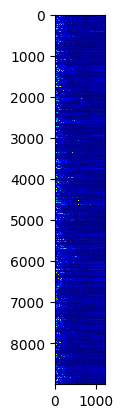

In [ ]:
x_grad = x_grad - x_grad.min(dim=1).values.unsqueeze(1).expand_as(x_grad)
x_grad = x_grad.div ((x_grad.max(dim=1).values-x_grad.min(dim=1).values).unsqueeze(1).expand_as(x_grad))

x_grad = x_grad.squeeze(0)
x_grad = x_grad.cpu().numpy()
print(x_grad)

# plot heatmap
plt.imshow(x_grad, cmap='jet', interpolation='nearest')
plt.show()

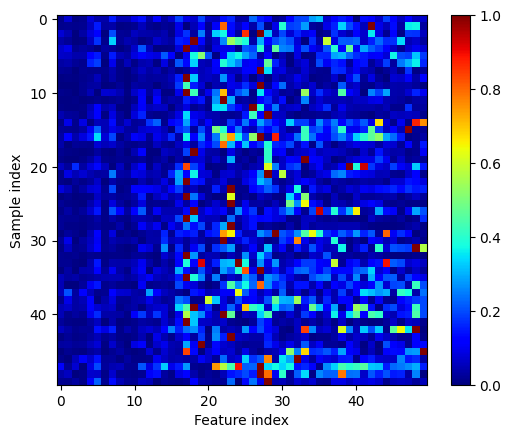

In [ ]:
x_grad_clip= x_grad[:50,:50]
plt.imshow(x_grad_clip, cmap='jet', interpolation='nearest')
plt.colorbar()
# plt.title('Contribution of features to the gradient of the output')
plt.xlabel('Feature index')
plt.ylabel('Sample index')
plt.show()


In [ ]:
non_zero_count = (x_grad != 0).sum(0)
x_grad_norm_sum = x_grad.sum(0)
x_grad_norm_sum[non_zero_count != 0] /= non_zero_count[non_zero_count != 0]
print(x_grad_norm_sum)

[0.02822946 0.03649594 0.02398228 ... 0.02895153 0.02706671 0.01134288]


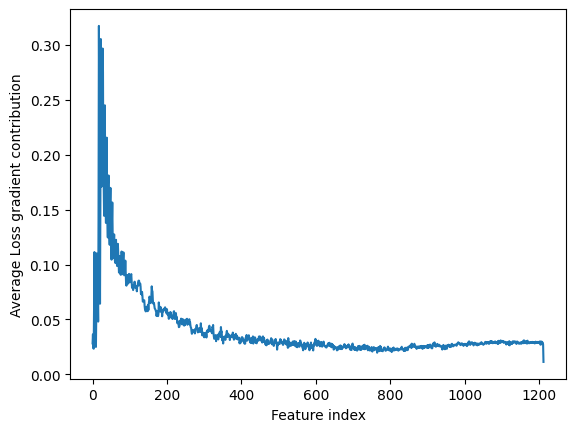

In [ ]:
x_grad_avg = x_grad_norm_sum
plt.plot(x_grad_avg)
# plt.title('Average Loss gradient contribution with respect to input')
plt.xlabel('Feature index')
plt.ylabel('Average Loss gradient contribution')
plt.show()

In [ ]:
print(np.argsort(x_grad_avg)[::-1][:50])


[17 22 27 23 28 33 18 32 38 37 43 25 26 42 29 24 30 48 34 21 53 47 39 35
 44 31 19 40 16 52 36 49 45 54 58 41 63 62 57 55 68 50 46 59 78 64  5 83
 11 67]


In [ ]:
x_z = x.squeeze(1)
x_loc = x_z>0
print(x_loc.sum())
print(np.sum(x_grad[x_loc]))
print(torch.numel(x_loc)-x_loc.sum())
print(np.sum(x_grad)-np.sum(x_grad[x_loc]))

pos_contrib = np.sum(np.abs(x_grad[x_loc]))/x_loc.sum()
neg_contrib = (np.sum(np.abs(x_grad))-np.sum(np.abs(x_grad[x_loc])))/(torch.numel(x_loc)-x_loc.sum())

print("Contribution due to outgoing packets: ", pos_contrib/(pos_contrib+neg_contrib))
print("Contribution due to incoming packets: ", neg_contrib/(pos_contrib+neg_contrib))


tensor(616995)
91057.46
tensor(10300005)
37620.734
Contribution due to outgoing packets:  tensor(0.9758)
Contribution due to incoming packets:  tensor(0.0242)


In [17]:
from torchviz import make_dot
val_loader2 = torch.utils.data.DataLoader(val_dataset, batch_size=9000, shuffle=True)
rnn.train()
x,y=next(iter(val_loader2))
y = rnn(x.unsqueeze(1).to(device))
y=y.float()
make_dot(y.mean(), params=dict(rnn.named_parameters())).render("rnn_torchviz", format="png")

'rnn_torchviz.png'